# Build a Reflective Self-Correcting Code Generation AI Agent

In this project we will be building an intelligent self-correction code generation AI Agent which can generate working code for user problems, leverage the reflection pattern to examine and test the code and improve and correct it.

![](https://i.imgur.com/koLDCZL.png)

### Reflective Self-Correcting Code Generation AI Agent

This project focuses on building a **Reflective Self-Correcting Code Generation AI Agent**, designed to iteratively generate, execute, and refine code to achieve accurate solutions. The workflow integrates reflective reasoning and error analysis to ensure robust and functional code generation. The workflow includes the following components:

1. **Code Generation**:
   - The system utilizes **OpenAI GPT-4o** to generate code based on the user's input and problem requirements.
   - Code is generated following a predefined schema, including:
     - **Prefix**: Problem description or setup requirements.
     - **Imports**: Necessary libraries or dependencies.
     - **Code**: Functional implementation of the solution.

2. **Code Execution and Reflection**:
   - The generated code is executed, and the results are analyzed.
   - If an error occurs, feedback is provided to refine the code:
     - **Error Feedback**: Captures errors or unexpected behaviors during execution.
     - **Reflection**: GPT-4o reflects on the error feedback to iteratively improve the solution.

3. **Iterative Correction Loop**:
   - The system repeats the generate-execute-reflect cycle until:
     - A successful solution is achieved (no errors).
     - The attempt count exceeds a predefined threshold (`N`), ensuring the loop terminates if a solution cannot be reached.

4. **Attempt Counter**:
   - Tracks the number of attempts (`K`) and increments with each iteration.
   - If the attempt count exceeds the predefined threshold, the process halts, and the user is informed.

5. **Final Validation**:
   - Once the code passes execution without errors, the refined solution is presented to the user as the final output.

6. **User Feedback Loop**:
   - If the user is unsatisfied with the solution, the process can be restarted to refine the code further or adjust the requirements.




## Install OpenAI, LangGraph and LangChain dependencies

In [ ]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64

## Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

## Setup Environment Variables

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Build Code Generator

In [41]:
from langchain_openai import ChatOpenAI
from langchain.prompts.chat import ChatPromptTemplate
from pydantic import BaseModel, Field


# Initialize GPT-4o
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# Prompt
CODE_GEN_SYS_PROMPT = [
        (
            "system",
            """You are a coding assistant.
                Ensure any code you provide can be executed with all required imports and variables defined.
                Make sure point 3 below has some code to run and execute any code or functions which you define

                Structure your answer as follows:
                  1) a prefix describing the code solution
                  2) the imports (if no imports needed keep it empty string)
                  3) the functioning code blocks

                Here is the user question:""",
        )
]

# Data model
class Code(BaseModel):
    """Schema for code solutions to questions about coding."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Just the import statements of the code")
    code: str = Field(description="Code blocks not including import statements")

# LLM
code_generator = llm.with_structured_output(Code)

In [42]:
question = "How to create fibonacci series"
messages = [("user", question)]

result = code_generator.invoke(CODE_GEN_SYS_PROMPT + messages)
result

Code(prefix="To create a Fibonacci series, we can use a simple iterative approach. The Fibonacci sequence is a series of numbers where each number is the sum of the two preceding ones, usually starting with 0 and 1. Here's a Python function to generate the Fibonacci series up to a specified number of terms.", imports='', code='def fibonacci_series(n):\n    fib_sequence = []\n    a, b = 0, 1\n    for _ in range(n):\n        fib_sequence.append(a)\n        a, b = b, a + b\n    return fib_sequence\n\n# Example usage:\nnum_terms = 10\nprint(f"Fibonacci series up to {num_terms} terms:", fibonacci_series(num_terms))\n\n# This will output: Fibonacci series up to 10 terms: [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]')

In [43]:
print(result.code)

def fibonacci_series(n):
    fib_sequence = []
    a, b = 0, 1
    for _ in range(n):
        fib_sequence.append(a)
        a, b = b, a + b
    return fib_sequence

# Example usage:
num_terms = 10
print(f"Fibonacci series up to {num_terms} terms:", fibonacci_series(num_terms))

# This will output: Fibonacci series up to 10 terms: [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]


In [44]:
print(result.imports)

We create a chain that returns structured data for code solutions. We’ll feed it the user’s question plus the system directive in the prompt above.

## Build Agent Graph Node Functions

The key focus here will be to create the function implementations of the main nodes in our graph which will include:

-  **Generate** a code solution
-  **Check code** imports and code execution and add error messages if any
- **Conditional routing** to regenerate code by reflecting on the errors if any OR stop generation



### Create Agent State Schema

In [45]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import HumanMessage

class CodeGenState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error_flag : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        code_solution : Code solution
        attempts : Number of tries
    """
    error_flag: str
    messages: Annotated[List[AnyMessage], add_messages]
    code_solution: str
    attempts: int

### Node 1: Generate Code

In [ ]:

def generate_code(state: CodeGenState) -> CodeGenState:
    """Generate code solution from GPT-4o, structured as prefix/imports/code."""
    print("--- GENERATING CODE SOLUTION ---")
    msgs = state["messages"]
    attempts_so_far = state["attempts"]

    # Call code_generation_chain
    code_soln = code_generator.invoke(CODE_GEN_SYS_PROMPT + msgs)

    # We'll record the chain's answer as a new assistant message in conversation.
    new_msg_content = (f"Here is my solution attempt:\n\nDescription: {code_soln.prefix}\n\n"
                       f"Imports: {code_soln.imports}\n\n"
                       f"Code:\n{code_soln.code}")

    msgs.append(("assistant", new_msg_content))
    attempts_so_far += 1

    return {
        "messages": msgs,
        "code_solution": code_soln,
        "attempts": attempts_so_far
    }

### Node 2: Check Code

We try to `exec` the imports, then `exec` the code. If errors occur, we pass them back to the conversation. Otherwise, success.

In [46]:
# sample code of how exec works
user_code = """
x = 5
y = 15
print('Result:', x * y)
"""
exec(user_code)

Result: 75


In [53]:
def check_code_execution(state: CodeGenState) -> CodeGenState:
    print("--- CHECKING CODE EXECUTION ---")
    msgs = state["messages"]
    code_soln = state["code_solution"]
    imports_str = code_soln.imports
    code_str = code_soln.code
    attempts = state["attempts"]

    # Attempt to import:
    try:
        exec(imports_str)
    except Exception as e:
        # Import failed
        print("---CODE IMPORT CHECK: FAILED---")
        error_msg = f"""Import test failed!
                        Here is the exception trace details:
                        {e}.

                        Please fix the import section."""

        msgs.append(("user", error_msg))
        return {
            "code_solution": code_soln,
            "attempts": attempts,
            "messages": msgs,
            "error_flag": "yes"
        }

    # Attempt to run code:
    try:
        scope = {}
        exec(f"{imports_str}\n{code_str}", scope)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_msg =  f"""Your code solution failed the code execution test!
                            Here is the exception trace details:
                            {e}

                            Reflect on this error and your prior attempt to solve the problem.

                            (1) State what you think went wrong with the prior solution
                            (2) try to solve this problem again.

                            Return the FULL SOLUTION.

                            Use the code tool to structure the output with a prefix, imports, and code block."""

        msgs.append(("user", error_msg))
        return {
            "code_solution": code_soln,
            "attempts": attempts,
            "messages": msgs,
            "error_flag": "yes"
        }

    # If no errors:
    print("--- NO ERRORS FOUND ---")
    return {
            "code_solution": code_soln,
            "attempts": attempts,
            "messages": msgs,
            "error_flag": "no"
    }

### Conditional Routing to Decide Next Step

In [54]:
MAX_ATTEMPTS = 3

def decide_next(state: CodeGenState) -> str:
    """If error or attempts < MAX_ATTEMPTS => go generate. Else end."""
    err = state["error_flag"]
    attempts = state["attempts"]
    if err == "no" or attempts >= MAX_ATTEMPTS:
        print("--- DECISION: FINISH ---")
        return "__end__"
    else:
        print("--- DECISION: RETRY ---")
        return "generate_code"

## Build the Reflection Agentic Graph

We'll define the nodes and edges in LangGraph, then run it.

In [55]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage

graph = StateGraph(CodeGenState)

# Add nodes:
graph.add_node("generate_code", generate_code)
graph.add_node("check_code", check_code_execution)

# Edges:
graph.set_entry_point("generate_code")
graph.add_edge("generate_code", "check_code")
graph.add_conditional_edges(
    "check_code",
    decide_next,
    [END, "generate_code"]
)

coder_agent = graph.compile()


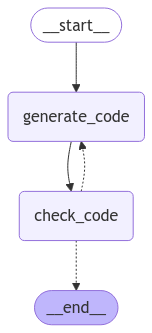

In [56]:
from IPython.display import display, Image, Markdown

display(Image(coder_agent.get_graph().draw_mermaid_png()))

## Run and Test the Agent

In [57]:
from langchain_core.messages import HumanMessage

def call_reflection_coding_agent(agent, prompt, verbose=False):
    events = agent.stream(
        {"messages": [HumanMessage(content=prompt)], "attempts": 0},
        stream_mode="values",
    )

    print('Running Agent. Please wait...')
    for event in events:
        if verbose:
            event["messages"][-1].pretty_print()

    print('\n\nFinal Solution:')
    print("\nDescription:\n" + event["code_solution"].prefix +
          "\nCode:\n"+event["code_solution"].imports + '\n\n' + event["code_solution"].code)

In [58]:
prompt = "write some code to demonstrate how to do a pivot table in pandas"
call_reflection_coding_agent(coder_agent, prompt, verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

write some code to demonstrate how to do a pivot table in pandas
--- GENERATING CODE SOLUTION ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: To create a pivot table in pandas, you can use the `pivot_table` method. This method allows you to summarize and aggregate data in a DataFrame. Below is an example demonstrating how to create a pivot table using a sample dataset.

Imports: import pandas as pd

Code:
# Sample data
# Creating a DataFrame with some sample data

data = {
    'Date': ['2023-01-01', '2023-01-01', '2023-01-02', '2023-01-02', '2023-01-03'],
    'Category': ['A', 'B', 'A', 'B', 'A'],
    'Sales': [100, 150, 200, 250, 300],
    'Quantity': [1, 2, 3, 4, 5]
}

df = pd.DataFrame(data)

# Display the original DataFrame
print("Original DataFrame:")
print(df)

# Creating a pivot table
# We

In [59]:
prompt = "write some code to scrape data from any wikipedia page"
call_reflection_coding_agent(coder_agent, prompt, verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

write some code to scrape data from any wikipedia page
--- GENERATING CODE SOLUTION ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: To scrape data from a Wikipedia page, we can use the BeautifulSoup library in Python. This library allows us to parse HTML and XML documents and extract data from them. In this example, we'll scrape the title and the first paragraph of a Wikipedia page.

Imports: import requests
from bs4 import BeautifulSoup

Code:
# URL of the Wikipedia page we want to scrape
target_url = "https://en.wikipedia.org/wiki/Web_scraping"

# Send a GET request to the URL
response = requests.get(target_url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the page content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract the titl

In [60]:
prompt = """Give me working code to get data from Twitter using API"""
call_reflection_coding_agent(coder_agent, prompt, verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

Give me working code to get data from Twitter using API
--- GENERATING CODE SOLUTION ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: To access data from Twitter using their API, you need to use the Tweepy library, which is a Python wrapper for the Twitter API. First, you need to create a Twitter Developer account and create an app to get your API keys and tokens. Once you have these credentials, you can use Tweepy to authenticate and fetch data from Twitter.

Imports: import tweepy

Code:
# Replace these with your own credentials
API_KEY = 'your_api_key'
API_SECRET_KEY = 'your_api_secret_key'
ACCESS_TOKEN = 'your_access_token'
ACCESS_TOKEN_SECRET = 'your_access_token_secret'

# Authenticate to Twitter
auth = tweepy.OAuth1UserHandler(API_KEY, API_SECRET_KEY, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# C

In [61]:
prompt = """Give me working code to do sentiment analysis using transformers"""
call_reflection_coding_agent(coder_agent, prompt, verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

Give me working code to do sentiment analysis using transformers
--- GENERATING CODE SOLUTION ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: To perform sentiment analysis using transformers, we can use the Hugging Face Transformers library. This library provides pre-trained models that can be easily used for various NLP tasks, including sentiment analysis. We'll use the `pipeline` function from the Transformers library to create a sentiment analysis pipeline with a pre-trained model. This approach is simple and effective for quick sentiment analysis tasks.

Imports: from transformers import pipeline

Code:
# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Example text for sentiment analysis
texts = [
    "I love this product! It's amazing.",
    "This 

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Text: I love this product! It's amazing.
Sentiment: POSITIVE, Score: 0.9999

Text: This is the worst experience I've ever had.
Sentiment: NEGATIVE, Score: 0.9998

Text: I'm not sure how I feel about this.
Sentiment: NEGATIVE, Score: 0.9992

Text: The service was okay, nothing special.
Sentiment: NEGATIVE, Score: 0.9862

Text: Absolutely fantastic! Highly recommend it.
Sentiment: POSITIVE, Score: 0.9999

--- NO ERRORS FOUND ---
--- DECISION: FINISH ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: To perform sentiment analysis using transformers, we can use the Hugging Face Transformers library. This library provides pre-trained models that can be easily used for various NLP tasks, including sentiment analysis. We'll use the `pipeline` function from the Transformers library to create a sentiment analysis pipeline with a pre-trained model. This approach is simple and effective for quick sentiment analysis task